In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from tqdm import notebook
import scipy.signal
import pdb

%config IPCompleter.greedy=True
%config InlineBackend.figure_format='retina'


#Get data
# pytorch wrapper to load dataset
from Generate_Data import *
class raman_dataset_fast(Dataset):
    def __init__(self, dataset, size):
        self.cars_data, self.raman_data = generate_datasets(dataset,size)
         
    def __len__(self):
        return len(self.raman_data)

    def __getitem__(self, idx):
        raman_data = self.raman_data[idx]
        cars_data = self.cars_data[idx]
        return raman_data, cars_data


class raman_dataset(Dataset):
    def __init__(self, file_path, raman_file, cars_file):
        self.raman_data = pd.read_csv(os.path.join(file_path, raman_file)).iloc[:, 1:]
        self.cars_data = pd.read_csv(os.path.join(file_path, cars_file)).iloc[:, 1:]
        
    def __len__(self):
        return len(self.raman_data)

    def __getitem__(self, idx):
        raman_data = self.raman_data.values[idx]
        cars_data = self.cars_data.values[idx]
        return raman_data, cars_data


    

# construct autoencoder
class encoder(nn.Module):
    def __init__(self, data_len, inplanes, planes, kernel_size, stride=1, padding=0):
        super(encoder, self).__init__()
        self.feature_len = cal_conv_feature(data_len, kernel_size, stride, padding)
        # if self.feature_len % 2 != 0:
        #     padding = 1
        # self.feature_len = cal_conv_feature(data_len, kernel_size, stride, padding)

        self.conv1 = nn.Conv1d(inplanes, planes, 
                                kernel_size=kernel_size, 
                                stride=stride, bias=False, padding=padding)
        self.bn1 = nn.BatchNorm1d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)    
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x

# construct autoencoder
class decoder(nn.Module):
    def __init__(self, data_len, data_len_match, inplanes, planes, kernel_size, stride=1, padding=0,
                dilation=1, output_padding=0):
        super(decoder, self).__init__()
        self.feature_len = cal_dconv_feature(data_len, kernel_size, stride, padding, dilation, output_padding)
        if data_len_match > self.feature_len:
            output_padding = data_len_match - self.feature_len
        else:
            output_padding = 0
        self.feature_len = cal_dconv_feature(data_len, kernel_size, stride, padding, dilation, output_padding)

        self.conv1 = nn.ConvTranspose1d(inplanes, planes, 
                                        kernel_size=kernel_size, 
                                        stride=stride, bias=False, 
                                        padding=padding,
                                        dilation=dilation,
                                        output_padding=output_padding)
        self.bn1 = nn.BatchNorm1d(num_features=planes)
        self.relu = nn.ReLU(inplace=True)    
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        return x





# construct autoencoder
class autoencoder(nn.Module):
    def __init__(self, data_len, kernel_size):
        super(autoencoder, self).__init__()

        kernel_size = kernel_size
        print('Kernel size: {}'.format(kernel_size))

        self.encoder1 = encoder(data_len=data_len, inplanes=1, planes=64, 
                                kernel_size=kernel_size, stride=1, padding=0)
        self.en1_num_feature = self.encoder1.feature_len
            

        self.encoder2 = encoder(data_len=self.en1_num_feature, inplanes=64, planes=128, 
                                kernel_size=kernel_size, stride=2, padding=0)
        self.en2_num_feature = self.encoder2.feature_len

             
        self.encoder3 = encoder(data_len=self.en2_num_feature, inplanes=128, planes=256, 
                                kernel_size=kernel_size, stride=2, padding=0)
        self.en3_num_feature = self.encoder3.feature_len
            

        self.encoder4 = encoder(data_len=self.en3_num_feature, inplanes=256, planes=512, 
                                kernel_size=kernel_size, stride=2, padding=0)
        self.en4_num_feature = self.encoder4.feature_len

        self.encoder5 = encoder(data_len=self.en4_num_feature, inplanes=512, planes=1024, 
                                kernel_size=kernel_size, stride=2, padding=0)
        self.en5_num_feature = self.encoder5.feature_len

        self.encoder6 = encoder(data_len=self.en5_num_feature, inplanes=1024, planes=2048, 
                                kernel_size=kernel_size, stride=2, padding=0)
        self.en6_num_feature = self.encoder6.feature_len


        print('Latent space dimension {}'.format(self.en5_num_feature))


        self.decoder1 = decoder(data_len=self.en6_num_feature, data_len_match=self.en5_num_feature, 
                                inplanes=2048, planes=1024, kernel_size=kernel_size, stride=2, padding=0)
 

        self.decoder2 = decoder(data_len=self.en5_num_feature, data_len_match=self.en4_num_feature, 
                                inplanes=1024, planes=512, kernel_size=kernel_size, stride=2, padding=0)


        self.decoder3 = decoder(data_len=self.en4_num_feature, data_len_match=self.en3_num_feature, 
                                inplanes=512, planes=256, kernel_size=kernel_size, stride=2, padding=0)


        self.decoder4 = decoder(data_len=self.en3_num_feature, data_len_match=self.en2_num_feature, 
                                inplanes=256, planes=128, kernel_size=kernel_size, stride=2, padding=0)
    

        self.decoder5 = decoder(data_len=self.en2_num_feature, data_len_match=self.en1_num_feature,
                                inplanes=128, planes=64, kernel_size=kernel_size, stride=2, padding=0)




        kernel_size = kernel_size
        stride = 1
        output_padding = 0
        padding = 0
        dilation = 1

        last_feature_len = cal_dconv_feature(self.en1_num_feature, kernel_size, stride, padding, dilation, output_padding)
        if data_len > last_feature_len:
            padding = data_len - last_feature_len
            pdb.set_trace()
        else:
            padding = 0
        self.feature_len = cal_dconv_feature(self.en1_num_feature, kernel_size, stride, padding, dilation, output_padding)

        self.decoder6 = nn.ConvTranspose1d(64, 1, 
                                            kernel_size=kernel_size, stride=stride, 
                                            bias=False,
                                            padding=padding,
                                            dilation = dilation,
                                            output_padding=output_padding)

        self.sigmoid = nn.Sigmoid()  



    def forward(self, x):
        x = x.unsqueeze(1)
        en1 = self.encoder1(x)
        en2 = self.encoder2(en1)
        en3 = self.encoder3(en2)
        en4 = self.encoder4(en3)
        en5 = self.encoder5(en4)
        encoding = self.encoder6(en5)
        
        
        de1 = self.decoder1(encoding)
        de2 = self.decoder2(de1+en5)
        de3 = self.decoder3(de2+en4)
        de4 = self.decoder4(de3+en3)
        de5 = self.decoder5(de4+en2)
        de6 = self.decoder6(de5)
        out = self.sigmoid(de6)
        return out.squeeze(1)





    
def loss_function(recon_x, x): #hidden_neurons_batch: [samples, number of neurons]
    # BCE = F.mse_loss(recon_x.view(-1, 1000), x.view(-1, 1000))
    BCE = F.l1_loss(recon_x.view(-1, 1000), x.view(-1, 1000))
    return BCE.cuda()

def adjust_learning_rate(learning_rate, optimizer, epoch, lr_steps):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr_new = learning_rate * (0.1 ** (sum(epoch >= np.array(lr_steps))))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_new


def cal_conv_feature(L_in, kernel_size, stride, padding):
    return (L_in - kernel_size + 2*padding) // stride + 1

def cal_dconv_feature(L_in, kernel_size, stride, padding, dilation, output_padding):
    return (L_in - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1





# define model function
# #A third option is to load the data from memory # need size1 to match size of training dataset 




lr = 1e-1
weight_decay = 5e-4
model = autoencoder(data_len=1000, kernel_size=8)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
model.to('cuda:0')

# training
epoch_num = 50
batch_size = 64

training_loss = []
val_loss = []


#choose dataset - numbers 1 to 9
dataset=1

print('Loading dataset.....')
dataset_train = raman_dataset_fast(dataset,50000)
train_loader = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=0)
dataset_val = raman_dataset_fast(dataset,5000)
val_loader = DataLoader(dataset_val, batch_size, shuffle=False, num_workers=0)




for epoch in notebook.trange(epoch_num):
    model.train()
    batch_loss = []
    for batch_i, inputs in enumerate(train_loader):
        raman = inputs[0].float().cuda()
        cars = inputs[1].float().cuda()

        optimizer.zero_grad()
        outputs = model(cars)

        loss = loss_function(outputs, raman)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())

    model.eval()
    with torch.no_grad():
        valid_loss = []
        for inputs in val_loader:
            raman = inputs[0].float().cuda()
            cars = inputs[1].float().cuda()
            outputs = model(cars)
            loss_valid = loss_function(outputs, raman)
            valid_loss.append(loss_valid.item())
        print('epoch: {}/{}, lr: {:.5f}, training loss: {:.5f}, valid loss: {:.5f}'.format(
                                                        epoch, 
                                                        epoch_num,
                                                        optimizer.param_groups[0]['lr'], 
                                                        np.mean(batch_loss),
                                                        np.mean(valid_loss)))
    training_loss.append(np.mean(batch_loss))
    val_loss.append(np.mean(valid_loss))
    adjust_learning_rate(lr, optimizer, epoch, [50, 100, 150])

Kernel size: 8
Latent space dimension 56
Loading dataset.....


epoch: 0/2, lr: 0.10000, training loss: 0.04421, valid loss: 0.01817
epoch: 1/2, lr: 0.10000, training loss: 0.01808, valid loss: 0.01799



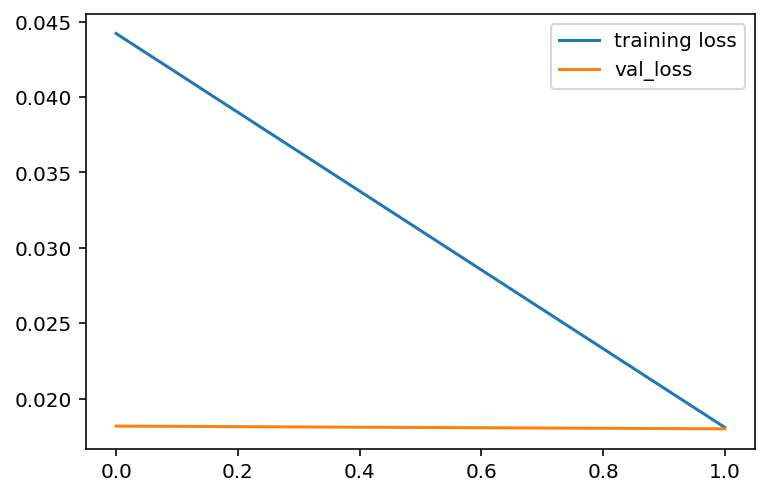

In [2]:
plt.plot(training_loss)
plt.plot(val_loss)
plt.legend(['training loss', 'val_loss'])

In [5]:
# set model to evluating mode. It is important to switch model from train() to eval() when doting testing !!!!!!
model.eval()

autoencoder(
  (encoder1): encoder(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (encoder2): encoder(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(2,), bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (encoder3): encoder(
    (conv1): Conv1d(128, 256, kernel_size=(8,), stride=(2,), bias=False)
    (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (encoder4): encoder(
    (conv1): Conv1d(256, 512, kernel_size=(8,), stride=(2,), bias=False)
    (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (encoder5): encoder(
    (conv1): Conv1d(512, 1024, kernel_size=(8,), stride=(2,), bias=False)
   

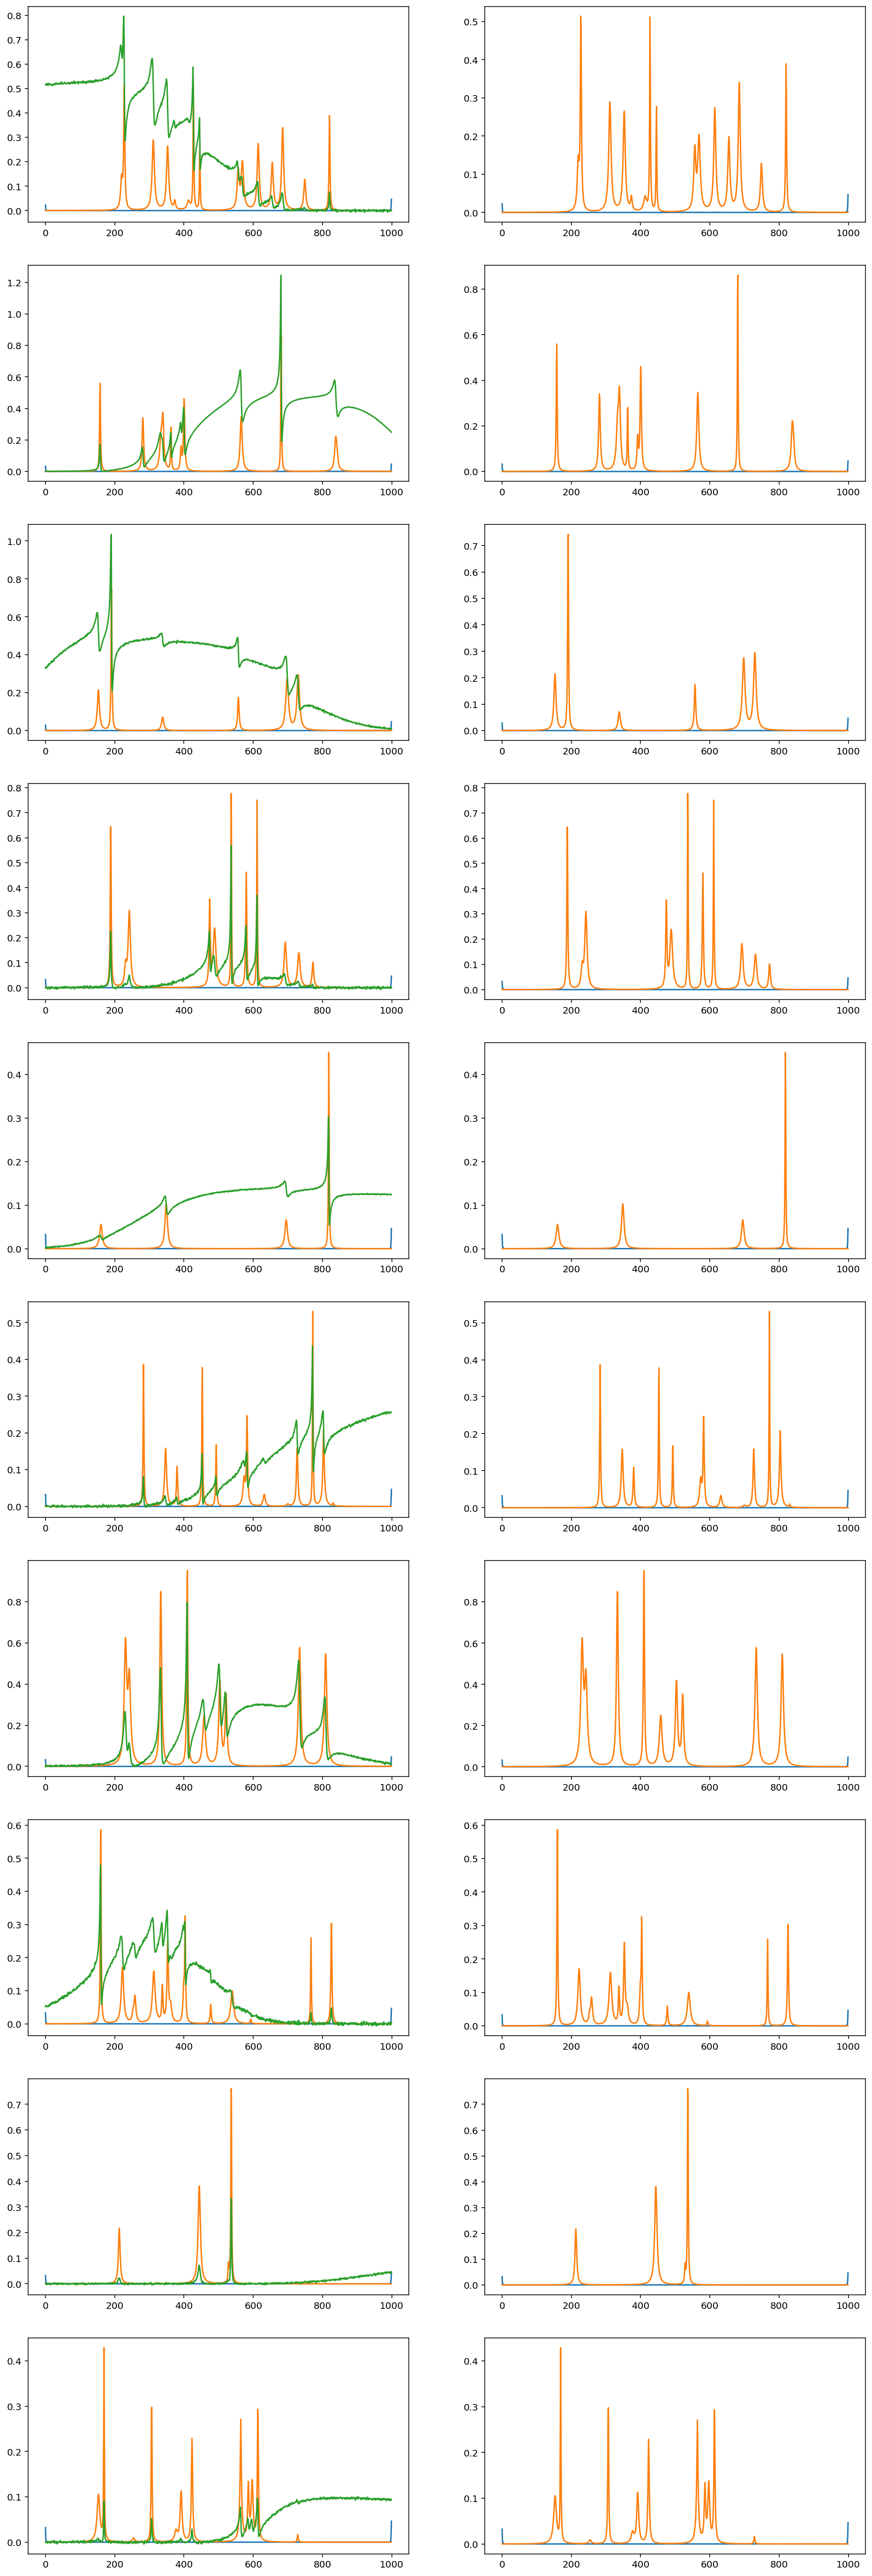

In [6]:
#test on 10 spectra from validation set
plt.figure(figsize=(16,50))
model.eval()
i = 0
n=10
m=20
with torch.no_grad():
    for ind in range(n, m):
        raman =  torch.Tensor(dataset_val[ind][0]).view(1,-1).squeeze(1).float().cuda()
        cars = torch.Tensor(dataset_val[ind][1]).view(1,-1).squeeze(1).float().cuda()
        outputs = model(cars)
        plt.subplot(10,2,i*2+1)
        plt.plot(outputs.data.cpu().numpy()[0])
        plt.plot(raman.data.cpu().numpy()[0])
        plt.plot(cars.data.cpu().numpy()[0])


        plt.subplot(10,2,i*2+2)
        plt.plot(outputs.data.cpu().numpy()[0])
        plt.plot(raman.data.cpu().numpy()[0])
        i += 1